In [30]:
import torch

torch.manual_seed(0)

# tensor，叶子节点

In [31]:
# 为了方便，随机创建一些int型的tensor，然后将它们转换为float型
X   = torch.randint(5, (4,)  ).float().requires_grad_(False)
W_1 = torch.randint(5, (2, 4)).float().requires_grad_(True)
Z   = W_1.matmul(X)
W_2 = torch.randint(5, (2,)  ).float().requires_grad_(True)
Y   = W_2.matmul(Z)

print(" X: \t%s \n W_1: \t%s \n Z: \t%s \n W_2: \t%s \n Y: \t%s \n" % (X, W_1, Z, W_2, Y))

 X: 	tensor([4., 4., 3., 0.]) 
 W_1: 	tensor([[3., 4., 2., 3.],
        [2., 3., 1., 1.]], requires_grad=True) 
 Z: 	tensor([34., 23.], grad_fn=<MvBackward>) 
 W_2: 	tensor([1., 4.], requires_grad=True) 
 Y: 	tensor(126., grad_fn=<DotBackward>) 



In [32]:
print(" is leaf?")
print(" X: \t%s \n W_1: \t%s \n Z: \t%s \n W_2: \t%s \n Y: \t%s \n" % (X.is_leaf, W_1.is_leaf, Z.is_leaf, W_2.is_leaf, Y.is_leaf))

 is leaf?
 X: 	True 
 W_1: 	True 
 Z: 	False 
 W_2: 	True 
 Y: 	False 



# 梯度，反向传播

In [33]:
Y.backward()
print(" grad")
print(" X: \t%s \n W_1: \t%s \n Z: \t%s \n W_2: \t%s \n Y: \t%s \n" % (X.grad, W_1.grad, Z.grad, W_2.grad, Y.grad))

 grad
 X: 	None 
 W_1: 	tensor([[ 4.,  4.,  3.,  0.],
        [16., 16., 12.,  0.]]) 
 Z: 	None 
 W_2: 	tensor([34., 23.]) 
 Y: 	None 



# 梯度累积

In [34]:
Z.detach_()
W_2.detach_().requires_grad_(True)

Z_2 = W_2.matmul(Z)
Z_2.backward()

print(" grad2")
print(" Z: \t%s \n W_2: \t%s \n" % (Z.grad, W_2.grad))

# 可以发现detach_()以后require_grad信息被清除
# 但是grad还保留，第二次反向传播后，两次的grad累积了起来

 grad2
 Z: 	None 
 W_2: 	tensor([68., 46.]) 



# 参数更新

In [35]:
# 前向传播，参数是所有的叶子节点，后面的是参数
def forward(X, W_1, W_2):
    Z = W_1.matmul(X)
    Y = W_2.matmul(Z)
    return Y

# 初始化
X   = torch.randint(5, (4,)  ).float().requires_grad_(False)
W_1 = torch.randint(5, (2, 4)).float().requires_grad_(True)
W_2 = torch.randint(5, (2,)  ).float().requires_grad_(True)

learning_rate = 0.01

print(" X: \t%s \n W_1: \t%s \n W_2: \t%s \n" % (X, W_1, W_2))
print(" ====================================")

# 更新模块
for epoch in range(10):
    # 梯度清零
    if W_1.grad is not None:
        W_1.grad.zero_()
    if W_2.grad is not None:
        W_2.grad.zero_()
    
    # 前向传播
    Y = forward(X, W_1, W_2)
    
    # 反向传播
    Y.backward()
    
    # 参数更新（数据域）
    W_1 = W_1 - learning_rate * W_1.grad
    W_2 = W_2 - learning_rate * W_2.grad
    
    # 脱离计算图（参数更新过程中产生的）
    W_1.detach_().requires_grad_(True)
    W_2.detach_().requires_grad_(True)
    
    print(" for epoch %d, Y is %s" % (epoch, Y.data))

 X: 	tensor([3., 1., 1., 3.]) 
 W_1: 	tensor([[4., 3., 1., 4.],
        [1., 4., 4., 1.]], requires_grad=True) 
 W_2: 	tensor([4., 4.], requires_grad=True) 

 for epoch 0, Y is tensor(168.)
 for epoch 1, Y is tensor(152.1360)
 for epoch 2, Y is tensor(137.5519)
 for epoch 3, Y is tensor(124.1259)
 for epoch 4, Y is tensor(111.7461)
 for epoch 5, Y is tensor(100.3092)
 for epoch 6, Y is tensor(89.7202)
 for epoch 7, Y is tensor(79.8908)
 for epoch 8, Y is tensor(70.7396)
 for epoch 9, Y is tensor(62.1905)


# 线性回归模型

In [36]:
# 数据生成
# 直线的真实 a 和 b
a, b = torch.randint(1, 5, (1, )), torch.randint(1, 5, (1, ))
print(" a: %s \n b: %s" % (a, b))
# 生成 x
x = torch.rand((50, )) * 50
# 生成噪声
noise = torch.randn((50, ))
# 计算 y
y = a * x + b + noise

print(" \n top 5 datas:")
print(" x \t: %s \n noise \t: %s \n y \t: %s \n" % (x[0:5], noise[0:5], y[0:5]))

 a: tensor([2]) 
 b: tensor([1])
 
 top 5 datas:
 x 	: tensor([15.2550, 46.6000,  8.7955, 13.4917,  7.5340]) 
 noise 	: tensor([-0.0933,  0.6871, -0.8383,  0.0009,  0.8419]) 
 y 	: tensor([31.4167, 94.8871, 17.7527, 27.9842, 16.9099]) 



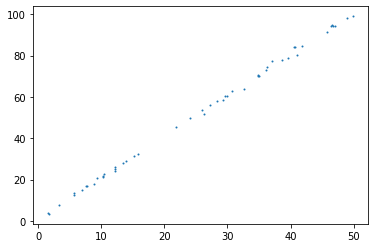

In [37]:
# 根据数据点画图
import matplotlib.pyplot as plt

plt.scatter(x, y, 1)
plt.show()

In [38]:
# 数据生成器，用于读取批量数据
def data_iter(batch_size, x, y):
    # 数据大小
    data_num = len(x)
    # 随机排列
    permutation = torch.randperm(data_num)
    # 每次取 batch_size 个
    for i in range(0, data_num, batch_size):
        # 每个 batch 的下标
        indices = permutation[i:i+batch_size]
        yield x[indices], y[indices]

In [39]:
# 参数初始化
A, B = torch.rand(1, requires_grad=True), torch.rand(1, requires_grad=True)
print(" target  A: %f, B: %f" % (a, b))
print(" initial A: %f, B: %f" % (A, B))
print(" ====================================")
# 训练阶段
epoch_num  = 5001
batch_size = 8
learning_rate = 0.001

for epoch in range(epoch_num):
    for X, Y in data_iter(batch_size, x, y):

        # 前向传播，计算损失
        Loss = ((A * X + B - Y) ** 2 / 2).sum()

        # 反向传播
        Loss.backward()

        # 更新参数
        A = (A - A.grad * learning_rate / batch_size).detach_().requires_grad_()
        B = (B - B.grad * learning_rate / batch_size).detach_().requires_grad_()

    if epoch % 500 == 0:
        print(" for epoch %d\t, Loss is %s" % (epoch, Loss.item()), end='\t')
        print(" A: %f, B: %f" % (A.item(), B.item()))

 target  A: 2.000000, B: 1.000000
 initial A: 0.840453, B: 0.496759
 for epoch 0	, Loss is 0.22005189955234528	 A: 2.010662, B: 0.531466
 for epoch 500	, Loss is 0.09574466943740845	 A: 1.973767, B: 0.947333
 for epoch 1000	, Loss is 0.03607318550348282	 A: 1.985599, B: 1.134936
 for epoch 1500	, Loss is 2.4995505809783936	 A: 1.990436, B: 1.220327
 for epoch 2000	, Loss is 0.23648767173290253	 A: 1.981476, B: 1.259384
 for epoch 2500	, Loss is 0.03790779411792755	 A: 1.974543, B: 1.276665
 for epoch 3000	, Loss is 0.6223516464233398	 A: 1.994190, B: 1.285105
 for epoch 3500	, Loss is 0.239980548620224	 A: 1.986317, B: 1.287909
 for epoch 4000	, Loss is 0.667565107345581	 A: 1.998233, B: 1.291380
 for epoch 4500	, Loss is 0.466873437166214	 A: 1.959629, B: 1.289387
 for epoch 5000	, Loss is 0.9469639658927917	 A: 1.980472, B: 1.288054
